In [1]:
%load_ext autoreload
%autoreload 2
import extract_environment as ee
import time
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import geopy.distance

import os
import xarray as xr
import dask
from dask.distributed import Client


In [2]:
dir_env = '/home/kbrennan/phd/data/climate/present'
dir_track = '/home/kbrennan/phd/data/climate/tracks/present'
day = '20210628'

now = pd.to_datetime(day+'19', format='%Y%m%d%H')

In [3]:
cells = ee.load_cells(dir_track, day)

In [4]:
cell = cells[83]

In [5]:
env = ee.load_environments(dir_env, now)

In [6]:
const = ee.load_constants(dir_env)
env = xr.merge([env, const], combine_attrs="override", compat="override")

In [7]:
cookie = ee.cutout_cookie(cell, env, now)
cookie = ee.add_secondary_variables(cookie)

cookie = ee.rotate_cookie(cookie, cell)

cookie = ee.mask_disk(cookie, 25)

# cookie = ee.mask_topography(cookie)


In [8]:
subdomains = xr.open_dataset('/home/kbrennan/phd/data/climate/grids/subdomains_rot.nc')
subdomains

<xarray.Dataset>
Dimensions:       (time: 1, bnds: 2, rlat: 1542, rlon: 1542)
Coordinates:
  * time          (time) datetime64[ns] 2020-03-19T03:00:00
    lon           (rlat, rlon) float32 ...
    lat           (rlat, rlon) float32 ...
  * rlon          (rlon) float32 -18.86 -18.84 -18.82 ... 11.92 11.94 11.96
  * rlat          (rlat) float32 -14.86 -14.84 -14.82 ... 15.92 15.94 15.96
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] ...
    rotated_pole  |S1 ...
    NAL           (time, rlat, rlon) float32 ...
    SAL           (time, rlat, rlon) float32 ...
    AL            (time, rlat, rlon) float32 ...
    BI            (time, rlat, rlon) float32 ...
    EA            (time, rlat, rlon) float32 ...
    FR            (time, rlat, rlon) float32 ...
    IP            (time, rlat, rlon) float32 ...
    MD            (time, rlat, rlon) float32 ...
    ME            (time, rlat, rlon) float32 ...
    NA            (time, rlat, rlon) float32 ...
Attributes:
    history:  Tue Apr 16 17:10:15 2024: ncks -4 -L 1 -a -O /project/pr133/rcu...
    NCO:      netCDF Operators version 5.0.4 (Homepage = http://nco.sf.net, C...

In [29]:
dom = 'AL'
mean = xr.open_dataset('/net/litho/atmosdyn2/kbrennan/data/climate/cookies/present/composites/'+dom+'_mean.nc')
print('n_cookies',mean.n_cookies.values)
print(subdomains[dom].attrs['long_name'])

n_cookies 83
Alps 5,15,44,48


In [30]:
mean

<xarray.Dataset>
Dimensions:        (x: 51, y: 51, pressure: 8)
Coordinates:
  * pressure       (pressure) float32 200.0 300.0 400.0 ... 700.0 850.0 925.0
  * x              (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y              (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
Data variables: (12/79)
    U_10M          (x, y) float32 ...
    V_10M          (x, y) float32 ...
    VMAX_10M       (x, y) float32 ...
    T_2M           (x, y) float32 ...
    TD_2M          (x, y) float32 ...
    RELHUM_2M      (x, y) float32 ...
    ...             ...
    t_rel_start    timedelta64[ns] ...
    t_rel_end      timedelta64[ns] ...
    t_rel_max      timedelta64[ns] ...
    itime          float64 ...
    n_cookies      int64 83
    n_fields       (pressure, x, y) int64 ...

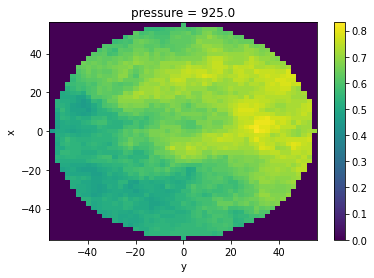

In [35]:
(mean.n_fields.sel(pressure=925)/mean.n_cookies).plot()

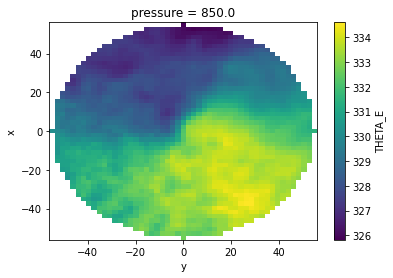

In [12]:
mean.THETA_E.sel(pressure=850).plot()

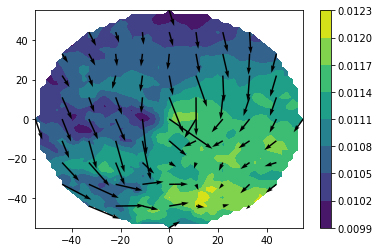

In [13]:
pressure = 925
plt.contourf(mean.x,mean.y,mean.QV.sel(pressure= pressure))
plt.colorbar()
stride= 5
plt.quiver(mean.x[::stride],mean.y[::stride],mean.U.sel(pressure=pressure)[::stride,::stride],mean.V.sel(pressure=pressure)[::stride,::stride], scale=50)

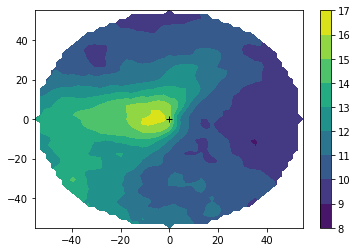

In [14]:
plt.contourf(mean.x,mean.y,mean.VMAX_10M)
plt.colorbar()
plt.plot(0,0,'k+')

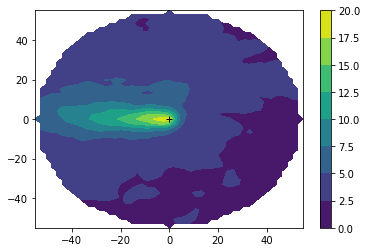

In [15]:
plt.contourf(mean.x,mean.y,mean.W_CTMAX)
plt.colorbar()
plt.plot(0,0,'k+')

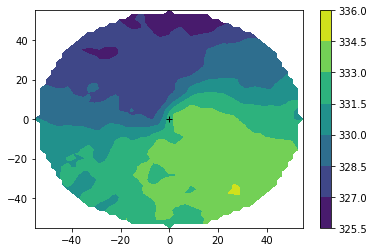

In [16]:
plt.contourf(mean.x,mean.y,mean.THETA_E.sel(pressure=850))
plt.colorbar()
plt.plot(0,0,'k+')

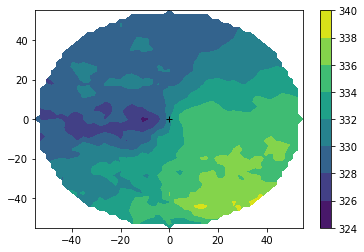

In [17]:
plt.contourf(mean.x,mean.y,mean.THETA_E.sel(pressure=925))
plt.colorbar()
plt.plot(0,0,'k+')

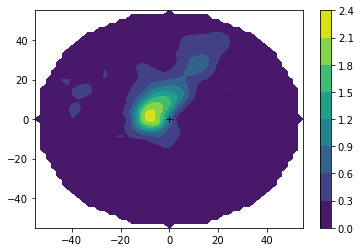

In [18]:
plt.contourf(mean.x,mean.y,mean.TOT_PREC)
plt.colorbar()
plt.plot(0,0,'k+')

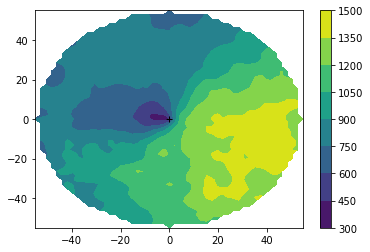

In [19]:
plt.contourf(mean.x,mean.y,mean.CAPE_MU)
plt.colorbar()
plt.plot(0,0,'k+')

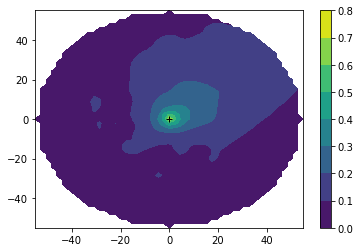

In [20]:
plt.contourf(mean.x,mean.y,mean.TQI)
plt.colorbar()
plt.plot(0,0,'k+')

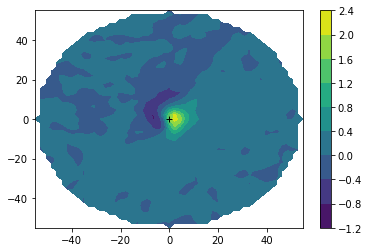

In [21]:
plt.contourf(mean.x,mean.y,mean.W.sel(pressure=850))
plt.plot(0,0,'k+')
plt.colorbar()

/tmp/ipykernel_40642/1248534744.py:3: UserWarning: No contour levels were found within the data range.
  plt.contour(mean.x,mean.y,mean.W.sel(pressure=850),levels=[5],colors='k')


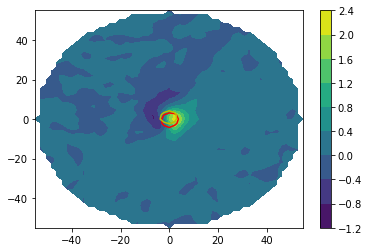

In [22]:
plt.contourf(mean.x,mean.y,mean.W.sel(pressure=850))
plt.colorbar()
plt.contour(mean.x,mean.y,mean.W.sel(pressure=850),levels=[5],colors='k')
plt.contour(mean.x,mean.y,mean.W.sel(pressure=600),levels=[5],colors='r')
plt.contour(mean.x,mean.y,mean.W.sel(pressure=300),levels=[5],colors='y')

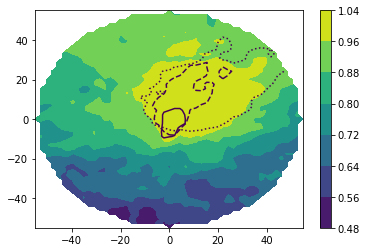

In [23]:
plt.contourf(mean.x,mean.y,mean.CLCT)
plt.colorbar()
plt.contour(mean.x,mean.y,mean.CLCL,levels=[0.6],linestyles=['solid'])
plt.contour(mean.x,mean.y,mean.CLCM,levels=[0.8],linestyles=['dashed'])
plt.contour(mean.x,mean.y,mean.CLCH,levels=[0.9],linestyles=['dotted'])